# Problem statement
Example 5.1 - Reinforcement Learning: An Introduction, Sutton and Barto, Second Edition - Monte Carlo

Blackjack is a card game where the goal is to obtain cards that sum to as near as possible to 21 without going over.  They're playing against a fixed dealer.

Face cards (Jack, Queen, King) have point value 10. Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck. The game starts with dealer having one face up and one face down card, while player having two face up cards. The player can request additional cards (hit=1) until they decide to stop (stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater.  If the dealer goes bust the player wins.

If neither player nor dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.  The reward for winning is +1, drawing is 0, and losing is -1.

The observation of a 3-tuple of: the players current sum (0-31), the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).

In this notebook, we calculate the optimal policy using the off-policy every-visit Monte-Carlo method with importance sampling to play Blackjack card game.

In [1]:
import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 

from utils import plotting
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Blackjack-v1')

In [3]:
def greedy_policy(action_values):
    """
    Creates a greedy policy based on the given action_values
    
    @action_values: maps from state -> action-values
    
    Returns:
        A function that takes the observation (state) as an argument and returns
        the probabilities for each action
    
    """
    def policy_fn(state):
        actions_prob = np.zeros_like(action_values[state], dtype=float)
        best_action = np.argmax(action_values[state])
        actions_prob[best_action] = 1.0
        return actions_prob
    return policy_fn

In [4]:
def random_policy(nA):
    """
    Creates a random policy function
    
    @nA: number of actions in the environment
    
    Returns:
        A function that takes the observation (state) as an argument and returns
        the probabilities for each action
    """
    actions_prob = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return actions_prob
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo control off-policy with importance sampling algorithm
    to find the optimal greedy policy
    
    @env: OpenAI environment
    @num_episodes: number of episodes to sample
    @behavior_policy: the behavior to follow while generating episodes
    @discount_factor: Gamma discount factor
    
    Returns:
        (action_values, policy) tuple
    """    
    # The final action-value function
    # maps state -> (action -> action-value)
    action_values = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # (C notation in the book)
    importance_sampling_denominator = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The greedy policy to be learnt
    target_policy = greedy_policy(action_values)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}", end="")
            sys.stdout.flush()

        # Generate an episode: a tuple of (state, action, reward)
        episode = []
        state = env.reset()
        for t in range(20):
            # Sample an action from the behavior policy
            probs = behavior_policy(state)
            # Pick a random action according to the behavior policy probabilities
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        G = 0.0 # Sum of discounted returns
        importance_sampling = 1.0 # (W notation in the book)
        for t in range(len(episode))[::-1]: # iterate backwards through the episode
            state, action, reward = episode[t]
            G = discount_factor * G + reward
            importance_sampling_denominator[state][action] += importance_sampling
            
            # Update the action-value function using the incremental update formula (5.7) of the book
            action_values[state][action] += (importance_sampling / importance_sampling_denominator[state][action]) * \
                                            (G - action_values[state][action])
            
            # Break if the action taken by the behavior policy is not the action 
            # taken by the target policy
            if action !=  np.argmax(target_policy(state)):
                break
            importance_sampling = importance_sampling * 1./behavior_policy(state)[action]
    
    return action_values, target_policy

In [6]:
random_policy = random_policy(env.action_space.n)
action_values, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000

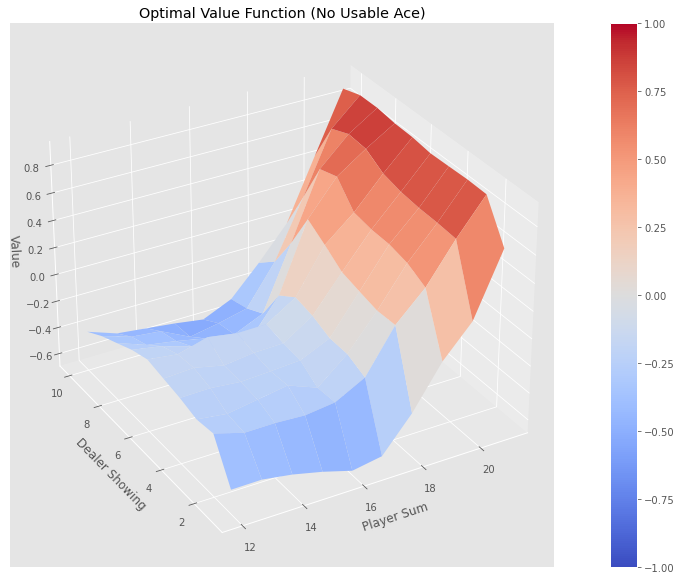

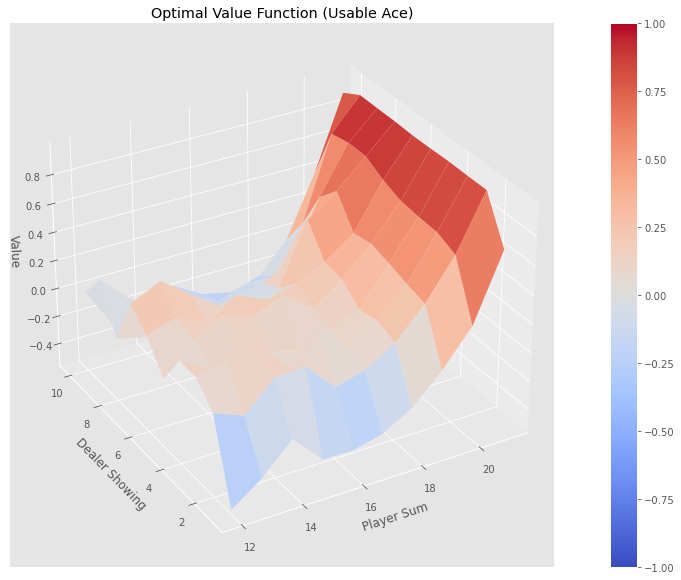

In [7]:
# Create state value function from action-value function
values = defaultdict(float)
for state, actions in action_values.items():
    action_value = np.max(actions)
    values[state] = action_value
plotting.plot_value_function(values, title="Optimal Value Function", minimum_x=12)